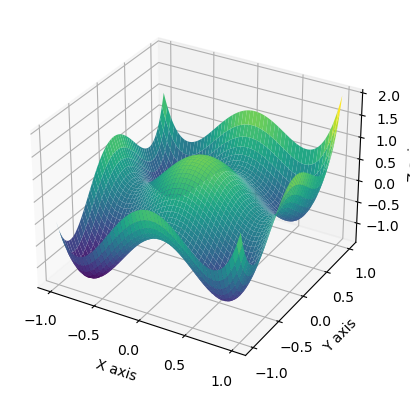

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the range of variables
x = np.linspace(-1, 1, 1000)
y = np.linspace(-1, 1, 1000)
x, y = np.meshgrid(x, y)

# Define the polynomial function.
# Here we use 3.2. Numerical Example 2. in 2308.16731, take D=2
z = 0.5 * (8 * x**4 - 8 * x**2 + 1 + 8 * y**4 - 8 * y**2 + 1) + (0.5 * (x + y))**3

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, z, cmap='viridis')

# Add axis labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Display the plot
plt.show()




In [9]:
from scipy.integrate import quad
# This block is for initialization according to the article, µ, {R_i^l, S_i^l},is initialized randomly using a distribution U ([−1, 1]) uniform over [−1, 1].

# def function of the moments in M_d
def f(x,i,j):
    return 1/2*x**(i+j)

# def function of the function in M_{d-1}
def g(x,i,j):
    return 1/2*(1-x**2)*x**(i+j)

# function generate M_d(mu_{i}^{l})
def M_d(d):
    matrix = np.zeros((d+1, d+1))
    for i in range(d+1):
        for j in range(d+1):
            matrix[i,j],_= quad(f,-1,1,args=(i,j))
    return matrix 

# function generate M_d(mu_{i}^{l})
def M_d_1(d):
    matrix = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            matrix[i,j],_= quad(g,-1,1,args=(i,j))
    return matrix 

# function generate R_i:
def R_i(d):
    matrix = np.random.uniform(-1, 1, size=(d+1, d+1))
    return matrix

# function generate S_i:
def S_i(d):
    matrix = np.random.uniform(-1, 1, size=(d, d))
    return matrix

# function generate phi(\mu), the formula is from (2.1)
def phi(x_0_M_D_L, x_1_M_D_L, d, L):
    matrix = np.zeros((d+1, d+1))
    for i in range(d+1):
        for j in range(d+1):
            for l in range(L):
                matrix[i,j]+=x_0_M_D_L[l][0,i]*x_1_M_D_L[l][0,j]
    return matrix


In [10]:
# Initialization part
#First step, we initialze the P_{n} which is the matrix of the coefficinets
p_n = np.array([
    [1, 0, -4, 1/8, 4],
    [0, 0, 3/8, 0, 0],
    [-4, 3/8, 0, 0, 0],
    [1/8, 0, 0, 0, 0],
    [4, 0, 0, 0, 0]
])

D = 2 #the number of the variables
L = 10 #the number of the measure
d = 4 #degree

# create two empty list for M_d(µ(l)i)
x_0_M_D_L = []
x_1_M_D_L = []

# create two empty list for M_{d-1}(µ(l)i)
x_0_M_D_1_L = []
x_1_M_D_1_L = []

# create two empty list for R_i^l
x_0_R_L = []
x_1_R_L = []

# create two empty list for S_i^l
x_0_S_L = []
x_1_S_L = []

#According to the number of measure, initialize the matrix using previous block function
for l in range(L):
    x_0_M_D_L.append(M_d(d))
    x_1_M_D_L.append(M_d(d))

    x_0_M_D_1_L.append(M_d_1(d))
    x_1_M_D_1_L.append(M_d_1(d))

    x_0_R_L.append(R_i(d))
    x_1_R_L.append(R_i(d))

    x_0_S_L.append(S_i(d))
    x_1_S_L.append(S_i(d))




# phi_mu = phi(x_0_M_D_L, x_1_M_D_L,d,L)
#first we need to solve the B.5 problem which implement L-BFGS, here we use the scipy.optimize.minimize (need further consideration) to do the calculation
#for convience of calculation we need to flatten the matrix into 1 dimension array which contains (d+1)^2*L*D*2+d^2*L*D*2 variables
#the way I choose to flatten the martix is easily by counting from martrix[0,0],[0,1],[0,2],...,[d+1,d+1] 

x_matrix_list = x_0_M_D_L+x_1_M_D_L+x_0_R_L+x_1_R_L+x_0_M_D_1_L+x_1_M_D_1_L+x_0_S_L+x_1_S_L

#create a empty variable for x0 and then initialize it with our initial values
x = np.array([])

start_index_list = []
start_index = 0
for matrix_index in range(len(x_matrix_list)):
    start_index_list.append(start_index)
    flattened_array = x_matrix_list[matrix_index].flatten()
    start_index += flattened_array.shape[0]
    x = np.concatenate((x, flattened_array))

start_index_list.append(L*D*2*((d+1)**2+d**2))   

# create a L*D*((d+1)**2+d**2+1) dimensions variable which are the Lagrangian_coefficients
Lagrangian_coefficients = np.zeros(L*D*((d+1)**2+d**2+1))



In [11]:
# This block is for restoring the matrix: x_0_M_D_L+x_1_M_D_L+x_0_R_L+x_1_R_L+x_0_M_D_1_L+x_1_M_D_1_L+x_0_S_L+x_1_S_L from the flattened x
def restore_matrices(x):
    # Define matrix dimensions
    md_shape = (d + 1, d + 1)
    md_1_shape = (d, d)
    # Initialize empty lists to store the restored matrices
    x_0_M_D_L = []
    x_1_M_D_L = []
    x_0_M_D_1_L = []
    x_1_M_D_1_L = []
    x_0_R_L = []
    x_1_R_L = []
    x_0_S_L = []
    x_1_S_L = []
    
    # Set the initial index
    start_index = 0
    
    for _ in range(L):
        # Restore M_d(d) matrices
        x_0_M_D_L.append(x[start_index:start_index + np.prod(md_shape)].reshape(md_shape))
        start_index += np.prod(md_shape)
    
    for _ in range(L):
        x_1_M_D_L.append(x[start_index:start_index + np.prod(md_shape)].reshape(md_shape))
        start_index += np.prod(md_shape)
    
    for _ in range(L):
        # Restore R_i(d) matrices
        x_0_R_L.append(x[start_index:start_index + np.prod(md_shape)].reshape(md_shape))
        start_index += np.prod(md_shape)

    for _ in range(L):
        x_1_R_L.append(x[start_index:start_index + np.prod(md_shape)].reshape(md_shape))
        start_index += np.prod(md_shape)
    
    for _ in range(L):
        # Restore M_d_1(d) matrices
        x_0_M_D_1_L.append(x[start_index:start_index + np.prod(md_1_shape)].reshape(md_1_shape))
        start_index += np.prod(md_1_shape)
    
    for _ in range(L):
        x_1_M_D_1_L.append(x[start_index:start_index + np.prod(md_1_shape)].reshape(md_1_shape))
        start_index += np.prod(md_1_shape)

    for _ in range(L):
        # Restore S_i(d) matrices
        x_0_S_L.append(x[start_index:start_index + np.prod(md_1_shape)].reshape(md_1_shape))
        start_index += np.prod(md_1_shape)
        
    for _ in range(L):
        x_1_S_L.append(x[start_index:start_index + np.prod(md_1_shape)].reshape(md_1_shape))
        start_index += np.prod(md_1_shape)

    return x_0_M_D_L,x_1_M_D_L,x_0_R_L,x_1_R_L,x_0_M_D_1_L,x_1_M_D_1_L,x_0_S_L,x_1_S_L

    

In [12]:
# This block is the collection of functions in the Augmented Lagrangian in B.3
# There are 3 terms

#This is the sum of the polynomials
def term_1(x_0_M_D_L, x_1_M_D_L):
    sum = 0
    phi_mu = phi(x_0_M_D_L, x_1_M_D_L,d,L)
    for i in range(d+1):
        for j in range(d+1):
            sum += p_n[i,j]*phi_mu[i,j]
    return sum

#This is for the Lagrangian term
def term_2(x_0_M_D_L, x_1_M_D_L, x_0_M_D_1_L, x_1_M_D_1_L, x_0_R_L, x_1_R_L, x_0_S_L, x_1_S_L):
    
    sum = 0
    Lagrangian_coefficients_index = 0
    # 1.Md(mu_0^(l)) - R_0^l R_0^l.T = 0
    for i in range(d+1):
        for j in range(d+1):
            for l in range(L):
                sum += Lagrangian_coefficients[Lagrangian_coefficients_index]*(x_0_M_D_L[l][i,j]-np.dot(x_0_R_L[l][i,:],x_0_R_L[l][j,:]))
                Lagrangian_coefficients_index +=1
    
    # 2.the Md(mu_1^(l)) - R_1^l R_1^l.T = 0
    for i in range(d+1):
        for j in range(d+1):
            for l in range(L):
                sum += Lagrangian_coefficients[Lagrangian_coefficients_index]*(x_1_M_D_L[l][i,j]-np.dot(x_1_R_L[l][i,:],x_1_R_L[l][j,:]))
                Lagrangian_coefficients_index +=1
        
    # 3.the Md-1(mu_0^(l)) - S_0^l S_0^l.T = 0
    for i in range(d):
        for j in range(d):
            for l in range(L):
                sum += Lagrangian_coefficients[Lagrangian_coefficients_index]*(x_0_M_D_1_L[l][i,j]-np.dot(x_0_S_L[l][i,:],x_0_S_L[l][j,:]))
                Lagrangian_coefficients_index +=1
    
    # 4. the Md-1(mu_1^(l)) - S_1^l S_1^l.T = 0
    for i in range(d):
        for j in range(d):
            for l in range(L):
                sum += Lagrangian_coefficients[Lagrangian_coefficients_index]*(x_1_M_D_1_L[l][i,j]-np.dot(x_1_S_L[l][i,:],x_1_S_L[l][j,:]))
                Lagrangian_coefficients_index +=1
                
    
    # 5. mu_(1,0)^l>=0
    for l in range(L):
        sum += Lagrangian_coefficients[Lagrangian_coefficients_index]*(x_0_M_D_L[l][0,0])
        Lagrangian_coefficients_index +=1
    
    # 6. mu_(i,0)^l - 1 = 0
    for l in range(L):
        sum += Lagrangian_coefficients[Lagrangian_coefficients_index]*(x_1_M_D_L[l][0,0]-1)
        Lagrangian_coefficients_index +=1
    
    return sum

#For the penanlty term, we initialze the rho as 10
def term_3(x_0_M_D_L, x_1_M_D_L, x_0_M_D_1_L, x_1_M_D_1_L, x_0_R_L, x_1_R_L, x_0_S_L, x_1_S_L):
    sum = 0 
    rho = 10
    # 1.Md(mu_0^(l)) - R_0^l R_0^l.T = 0
    for i in range(d+1):
        for j in range(d+1):
            for l in range(L):
                sum += rho/2*(x_0_M_D_L[l][i,j]-np.dot(x_0_R_L[l][i,:],x_0_R_L[l][j,:]))**2
    
    # 2.the Md(mu_1^(l)) - R_1^l R_1^l.T = 0
    for i in range(d+1):
        for j in range(d+1):
            for l in range(L):
                sum += rho/2*(x_1_M_D_L[l][i,j]-np.dot(x_1_R_L[l][i,:],x_1_R_L[l][j,:]))**2
        
    # 3.the Md-1(mu_0^(l)) - S_0^l S_0^l.T = 0
    for i in range(d):
        for j in range(d):
            for l in range(L):
                sum += rho/2*(x_0_M_D_1_L[l][i,j]-np.dot(x_0_S_L[l][i,:],x_0_S_L[l][j,:]))**2
    
    # 4. the Md-1(mu_1^(l)) - S_1^l S_1^l.T = 0
    for i in range(d):
        for j in range(d):
            for l in range(L):
                sum += rho/2*(x_1_M_D_1_L[l][i,j]-np.dot(x_1_S_L[l][i,:],x_1_S_L[l][j,:]))**2
                
    
    # 5. mu_(1,0)^l>=0 here we define the penalty term as max(0, -g)**2 since we need to let it >=0 
    # P.S Here we lack a good enough method to calculate the >=0 equation
    for l in range(L):
        sum += rho/2*(max(0,-x_0_M_D_L[l][0,0]))**2
    
    # 6. mu_(i,0)^l - 1 = 0
    for l in range(L):
        sum += rho/2*(x_1_M_D_L[l][0,0]-1)**2
    return sum
    

In [21]:
# We need to def the function of B.3
def Augmented_Lagrangian(x):
    """Here the x is the (328,) variable"""
    #Before we start, we need to reshape the x input back to the original format, which is the matrix form

    x_0_M_D_L,x_1_M_D_L,x_0_R_L,x_1_R_L,x_0_M_D_1_L,x_1_M_D_1_L,x_0_S_L,x_1_S_L = restore_matrices(x=x)
    
    sum_result = 0

    #First term
    sum_result += term_1(x_0_M_D_L, x_1_M_D_L)

    #Second term
    sum_result += term_2(x_0_M_D_L, x_1_M_D_L, x_0_M_D_1_L, x_1_M_D_1_L, x_0_R_L, x_1_R_L, x_0_S_L, x_1_S_L)
    
    #Third term
    sum_result += term_3(x_0_M_D_L, x_1_M_D_L, x_0_M_D_1_L, x_1_M_D_1_L, x_0_R_L, x_1_R_L, x_0_S_L, x_1_S_L)
    return sum_result




In [23]:
# update the Lagrangian_coefficients according to B.7
def update_Lagrangian_coefficients(x,Lagrangian_coefficients):
    #Before we start, we need to reshape the x input back to the original format
    #We set the penalty as 10
    rho = 10
    x_0_M_D_L,x_1_M_D_L,x_0_R_L,x_1_R_L,x_0_M_D_1_L,x_1_M_D_1_L,x_0_S_L,x_1_S_L = restore_matrices(x=x)

    Lagrangian_coefficients += rho*term_3(x_0_M_D_L, x_1_M_D_L, x_0_M_D_1_L, x_1_M_D_1_L, x_0_R_L, x_1_R_L, x_0_S_L, x_1_S_L)

In [19]:
from scipy.optimize import minimize
# In the article they use the L-BFGS, for test, we simply use the L-BFGS in scipy.optimize
# I think this is the main problem, we need to construct a better version of L-BFGS by ourselves

# Set optimization parameters
options = {
    'disp': True,  # Display convergence information
    'maxcor': 40,  # Number of corrections to approximate the Hessian (Approximation order 40)
    'ftol': 1e-5,  # Absolute stopping criterion (Stopping criterion - absolute value)
    'gtol': 1e-2,  # Relative gradient stopping criterion (Stopping criterion - relative gradient)
    'eps': 1e-8,   # Step size
    'maxiter': 15000  # Maximum number of iterations
}
result = minimize(Augmented_Lagrangian, x, method='L-BFGS-B',options=options)
print("-"*40)
print("Minimum value of the objective function:", result.fun)
print("Was the optimization successful?", result.success)
print("Number of iterations:", result.nit)
update_Lagrangian_coefficients(result.x,Lagrangian_coefficients)
print("-"*40)
x = result.x

----------------------------------------
Minimum value of the objective function: -6.801807258000994e+19
Was the optimization successful? False
Number of iterations: 1
6.743082596457311e+19
----------------------------------------


In [20]:
# This block is for the Algorithm B.2 Optimal location extraction (assuming unique global minimum)

x_0_M_D_L,x_1_M_D_L,_,_,_,_,_,_ = restore_matrices(x=result.x)

l_product_list = []
for l in range(L):
    l_product_list.append(x_0_M_D_L[l][0,0]*x_1_M_D_L[l][0,0])
max_index = l_product_list.index(max(l_product_list))
print(x_0_M_D_L[max_index][0,1]/(x_0_M_D_L[max_index][0,0]*x_1_M_D_L[max_index][0,0]))
print(x_1_M_D_L[max_index][0,1]/(x_0_M_D_L[max_index][0,0]*x_1_M_D_L[max_index][0,0]))


-0.0026665173074265315
-0.0026833375077505903
